In [11]:
import os
os.getcwd()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import seml
import pandas as pd

In [3]:
results = seml.get_results('final_full_CT_10reps', to_data_frame=True, parallel=True)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [7]:
results.to_csv("./results/results161123.csv")

In [4]:
groups = results.groupby(["config.addl_dataset_train", "config.n_hidden", "config.n_layers", "config.dropout_rate", "config.weight_decay"])
groups_mean = groups.mean(numeric_only=True)
groups_mean = groups_mean.reset_index()
#groups_extra.mean(numeric_only=True)[['result.r2_dbdb_healthy', 'result.r2_dbdb_OOD',
#                                'result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD']].sort_values("result.r2_dbdb_OOD", ascending=False)

In [5]:
groups_mean['avg_r2'] = groups_mean[['result.r2_dbdb_healthy', 'result.r2_dbdb_OOD','result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD']].mean(axis=1)
groups_mean['avg_r2_h'] = groups_mean[['result.r2_dbdb_healthy','result.r2_mSTZ_healthy']].mean(axis=1)
groups_mean['avg_r2_OOD'] = groups_mean[['result.r2_dbdb_OOD','result.r2_mSTZ_OOD']].mean(axis=1)

#result_extra_mean[['result.r2_dbdb_healthy', 'result.r2_dbdb_OOD',
#                   'result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD', 'avg_r2', 'avg_r2_h', 'avg_r2_OOD']].sort_values(by='avg_r2_OOD', ascending=False)


In [6]:
results_merged_genes = seml.get_results('exp021123_merged_genes', to_data_frame=True)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [7]:
groups = results_merged_genes.groupby(["config.addl_dataset_train", "config.n_hidden", "config.n_layers", "config.dropout_rate", "config.weight_decay"])
groups_mean_mg = groups.mean(numeric_only=True)
groups_mean_mg = groups_mean_mg.reset_index()
#groups_extra.mean(numeric_only=True)[['result.r2_dbdb_healthy', 'result.r2_dbdb_OOD',
#                                'result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD']].sort_values("result.r2_dbdb_OOD", ascending=False)

In [8]:
groups_mean_mg['avg_r2'] = groups_mean_mg[['result.r2_dbdb_healthy', 'result.r2_dbdb_OOD','result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD']].mean(axis=1)
groups_mean_mg['avg_r2_h'] = groups_mean_mg[['result.r2_dbdb_healthy','result.r2_mSTZ_healthy']].mean(axis=1)
groups_mean_mg['avg_r2_OOD'] = groups_mean_mg[['result.r2_dbdb_OOD','result.r2_mSTZ_OOD']].mean(axis=1)

#result_extra_mean[['result.r2_dbdb_healthy', 'result.r2_dbdb_OOD',
#                   'result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD', 'avg_r2', 'avg_r2_h', 'avg_r2_OOD']].sort_values(by='avg_r2_OOD', ascending=False)


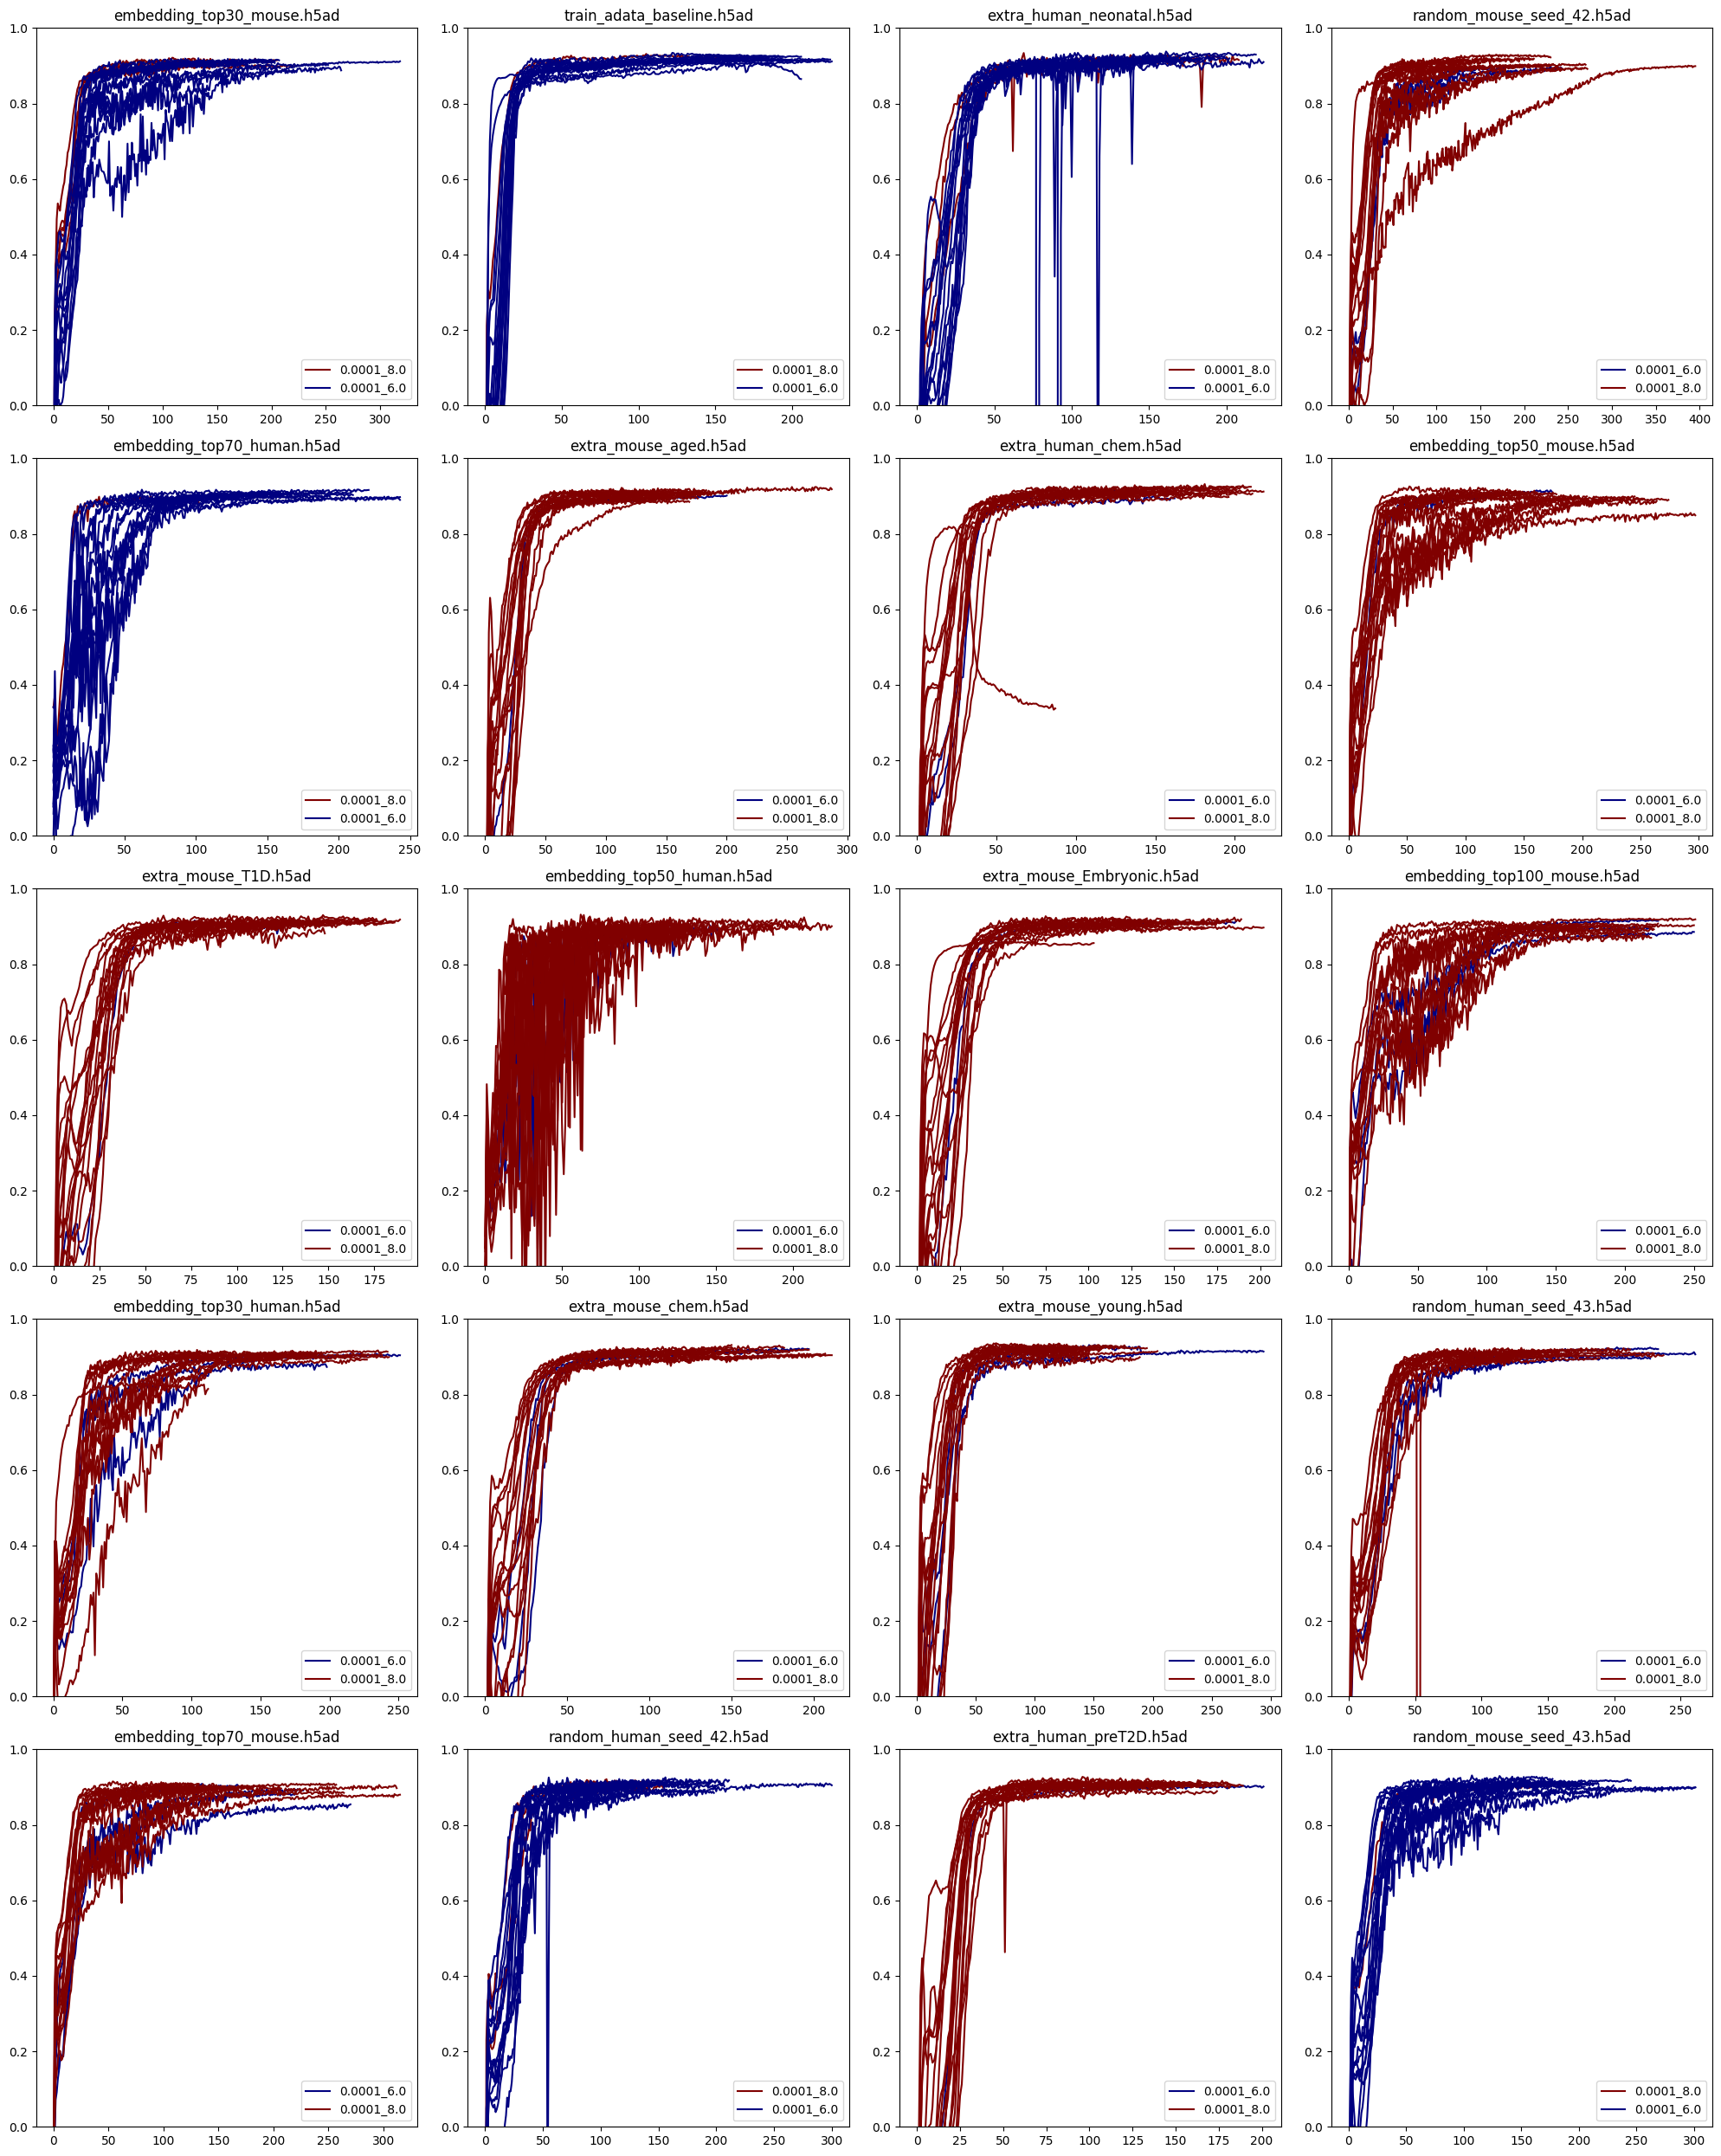

In [10]:
param1 = "config.dropout_rate"
param2 = "config.n_layers"
metric = "result.mean_r2_validation_eval"

save_dict = dict()
metric_df = metric.split(".")[1]

for dataset in results["config.addl_dataset_train"].unique():
    save_tmp_dict = dict()
    max_length = 0  # Variable to keep track of the max length of lists for the current dataset
    tmp_df = results[results["config.addl_dataset_train"] == dataset]
    
    # First pass to find the max_length
    for i, row in tmp_df.iterrows():
        length = len(row[metric][metric_df])
        if length > max_length:
            max_length = length
    
    # Second pass to collect and pad data
    for i, row in tmp_df.iterrows():
        combined_key = f"{row[param1]}_{row[param2]}_{i}"
        padded_list = [float(elm) for elm in row[metric][metric_df]] + [np.nan]*(max_length - len(row[metric][metric_df]))
        save_tmp_dict[combined_key] = padded_list

    # Now all lists in save_tmp_dict have the same length
    save_dict[dataset] = save_tmp_dict


# Extract unique parameter combinations and create a colormap for them
combined_params = [(row[param1], row[param2]) for _, row in results.iterrows()]
unique_params = list(set(combined_params))  # get unique combinations
colors = plt.cm.jet(np.linspace(0, 1, len(unique_params)))
color_map = dict(zip(unique_params, colors))

# Setup 5x4 subplots
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
axes = axes.ravel()  # Flatten the 5x4 array for easier iteration

# Loop through all datasets and plot them
for idx, dataset_key in enumerate(save_dict.keys()):
    df = pd.DataFrame(save_dict[dataset_key])

    plotted_params = set()
    for column in df.columns:
        values = column.rsplit("_", 1)[0]  # Extracting the combined parameter values from the column name
        if values not in plotted_params:
            param_values = tuple(map(float, values.split("_")))
            df[column].plot(ax=axes[idx], color=color_map[param_values], label=f'{param_values[0]}_{param_values[1]}')
            plotted_params.add(values)
        else:
            df[column].plot(ax=axes[idx], color=color_map[param_values], label='_nolegend_')

    # Set the title and limit for each subplot
    axes[idx].set_title(dataset_key)
    axes[idx].set_ylim([0, 1])
    axes[idx].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
#plt.savefig("fig_161123/161123_meanR2_validation_per_dataset_colored_by_dr_o_rate_n_layers.png")
plt.show()
